**Import libraries**

In [1]:
from sklearn.datasets import load_digits

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import joblib

import warnings

**Define libraries configurations**

In [2]:
warnings.filterwarnings(action="ignore")

**Define project constant variables**

In [3]:
RANDOM_STATE = 42
N_JOBS = -1

**Load input dataset**

In [4]:
X, y = load_digits(return_X_y=True)

**Split dataset into training and test sets**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

**Define base pipeline**

In [6]:
base_pipeline = Pipeline(
    steps=[
        ("Scaler", MinMaxScaler()),
        ("Model", RandomForestClassifier(oob_score=True, n_jobs=N_JOBS, random_state=RANDOM_STATE))
    ]
)
base_pipeline

Pipeline(steps=[('Scaler', MinMaxScaler()),
                ('Model',
                 RandomForestClassifier(n_jobs=-1, oob_score=True,
                                        random_state=42))])

**Perform cross validation on pipeline**

In [7]:
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

base_cv_scores = cross_val_score(estimator=base_pipeline, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
base_cv_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.6s finished


array([0.96527778, 0.98611111, 0.97222222, 0.98611111, 0.97222222,
       0.99305556, 0.96527778, 0.97202797, 0.97902098, 0.97902098])

**Get cross validation results**

In [8]:
print(f"Mean CV accuracy: {base_cv_scores.mean():.4f} +/- {base_cv_scores.std():.4f}")

Mean CV accuracy: 0.9770 +/- 0.0088


**Get pipeline parameters, to use for parameters optimization**

In [9]:
base_pipeline.get_params()

{'memory': None,
 'steps': [('Scaler', MinMaxScaler()),
  ('Model',
   RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42))],
 'verbose': False,
 'Scaler': MinMaxScaler(),
 'Model': RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42),
 'Scaler__clip': False,
 'Scaler__copy': True,
 'Scaler__feature_range': (0, 1),
 'Model__bootstrap': True,
 'Model__ccp_alpha': 0.0,
 'Model__class_weight': None,
 'Model__criterion': 'gini',
 'Model__max_depth': None,
 'Model__max_features': 'sqrt',
 'Model__max_leaf_nodes': None,
 'Model__max_samples': None,
 'Model__min_impurity_decrease': 0.0,
 'Model__min_samples_leaf': 1,
 'Model__min_samples_split': 2,
 'Model__min_weight_fraction_leaf': 0.0,
 'Model__n_estimators': 100,
 'Model__n_jobs': -1,
 'Model__oob_score': True,
 'Model__random_state': 42,
 'Model__verbose': 0,
 'Model__warm_start': False}

**Perform parameters optimization with random search**

In [10]:
params = {
    "Model__n_estimators": [25, 50, 100, 200, 250, 500],
    "Model__criterion": ["gini", "entropy"],
    "Model__max_depth": [None, 1, 2, 5, 10, 20],
    "Model__max_features": ["sqrt", "log2"],
    "Model__class_weight": [None, "balanced", "balanced_subsample"]
}

random_search = RandomizedSearchCV(estimator=base_pipeline, param_distributions=params, n_iter=20, 
                                   scoring="accuracy", n_jobs=N_JOBS, cv=skfold, verbose=1, random_state=RANDOM_STATE)
random_search.fit(X=X_train, y=y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('Scaler', MinMaxScaler()),
                                             ('Model',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     oob_score=True,
                                                                     random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'Model__class_weight': [None,
                                                                'balanced',
                                                                'balanced_subsample'],
                                        'Model__criterion': ['gini', 'entropy'],
                                        'Model__max_depth': [None, 1, 2, 5, 10,
                                                             20],
                                        'Model__max_features': ['sqrt', 'log2'],
                                        'Model__n_estimators': [25, 50, 100,
                                                                200, 250,
                                                                500]},
                   random_state=42, scoring='accuracy', verbose=1)

**Get random search best parameters and validation scores**

In [11]:
random_search.best_params_

{'Model__n_estimators': 200,
 'Model__max_features': 'log2',
 'Model__max_depth': None,
 'Model__criterion': 'gini',
 'Model__class_weight': None}

In [12]:
random_search.best_score_

0.9777389277389277

**Define pipeline with the best parameters**

In [13]:
best_pipeline = Pipeline(
    steps=[
        ("Scaler", MinMaxScaler()),
        ("Model", RandomForestClassifier(n_estimators=200, max_features="log2", oob_score=True, n_jobs=N_JOBS, random_state=RANDOM_STATE))
    ]
)
best_pipeline.fit(X=X_train, y=y_train)

Pipeline(steps=[('Scaler', MinMaxScaler()),
                ('Model',
                 RandomForestClassifier(max_features='log2', n_estimators=200,
                                        n_jobs=-1, oob_score=True,
                                        random_state=42))])

**Perform cross validation on new pipeline**

In [14]:
best_cv_scores = cross_val_score(estimator=best_pipeline, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
best_cv_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.0s finished


array([0.95833333, 0.99305556, 0.97916667, 0.97916667, 0.97222222,
       0.99305556, 0.95833333, 0.97902098, 0.97902098, 0.98601399])

**Get cross validation results**

In [15]:
print(f"Mean CV accuracy: {best_cv_scores.mean():.4f} +/- {best_cv_scores.std():.4f}")

Mean CV accuracy: 0.9777 +/- 0.0115


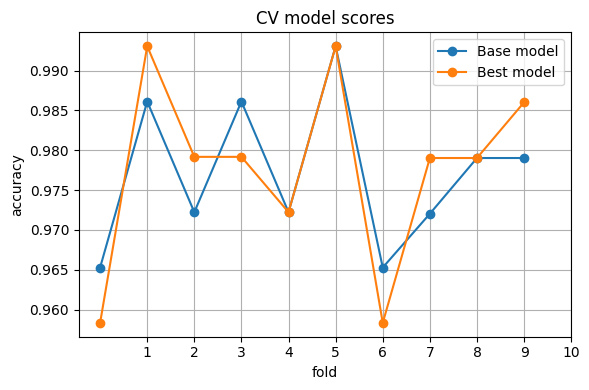

In [16]:
plt.figure(figsize=(6, 4))
plt.title("CV model scores")
plt.plot(base_cv_scores, marker="o")
plt.plot(best_cv_scores, marker="o")
plt.xticks(ticks=range(1, 11))
plt.xlabel("fold")
plt.ylabel("accuracy")
plt.legend(["Base model", "Best model"])
plt.tight_layout()
plt.grid()
plt.show()

**Compute pipeline predictions on test set**

In [17]:
y_pred = best_pipeline.predict(X=X_test)

**Compute classification metrics on test set**

In [18]:
report = classification_report(y_true=y_test, y_pred=y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.92      1.00      0.96        36
           2       1.00      1.00      1.00        35
           3       0.97      1.00      0.99        37
           4       0.97      1.00      0.99        36
           5       1.00      1.00      1.00        37
           6       1.00      0.97      0.99        36
           7       0.95      1.00      0.97        36
           8       0.94      0.89      0.91        35
           9       1.00      0.92      0.96        36

    accuracy                           0.97       360
   macro avg       0.98      0.97      0.97       360
weighted avg       0.98      0.97      0.97       360



**Serialize best fitted pipeline**

In [19]:
joblib.dump(value=best_pipeline, filename="models/digit_model.joblib")

['models/digit_model.joblib']